# SECTION 1: SETUP AND INITIAL DATA EXPLORATION

Successfully loaded Floor1.csv
Successfully loaded Floor2.csv
Successfully loaded Floor3.csv
Successfully loaded Floor4.csv
Successfully loaded Floor5.csv
Successfully loaded Floor6.csv
Successfully loaded Floor7.csv

--- Analyzing Floor6 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689128 entries, 0 to 689127
Data columns (total 30 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Date          689128 non-null  object 
 1   z1_AC1(kW)    688047 non-null  float64
 2   z1_Light(kW)  687983 non-null  float64
 3   z1_Plug(kW)   687893 non-null  float64
 4   z1_S1(degC)   416475 non-null  float64
 5   z1_S1(RH%)    416474 non-null  float64
 6   z1_S1(lux)    416472 non-null  float64
 7   z2_AC1(kW)    688054 non-null  float64
 8   z2_Light(kW)  687983 non-null  float64
 9   z2_Plug(kW)   688095 non-null  float64
 10  z2_S1(degC)   398223 non-null  float64
 11  z2_S1(RH%)    398223 non-null  float64
 12  z2_S1(lux)    398223 non-

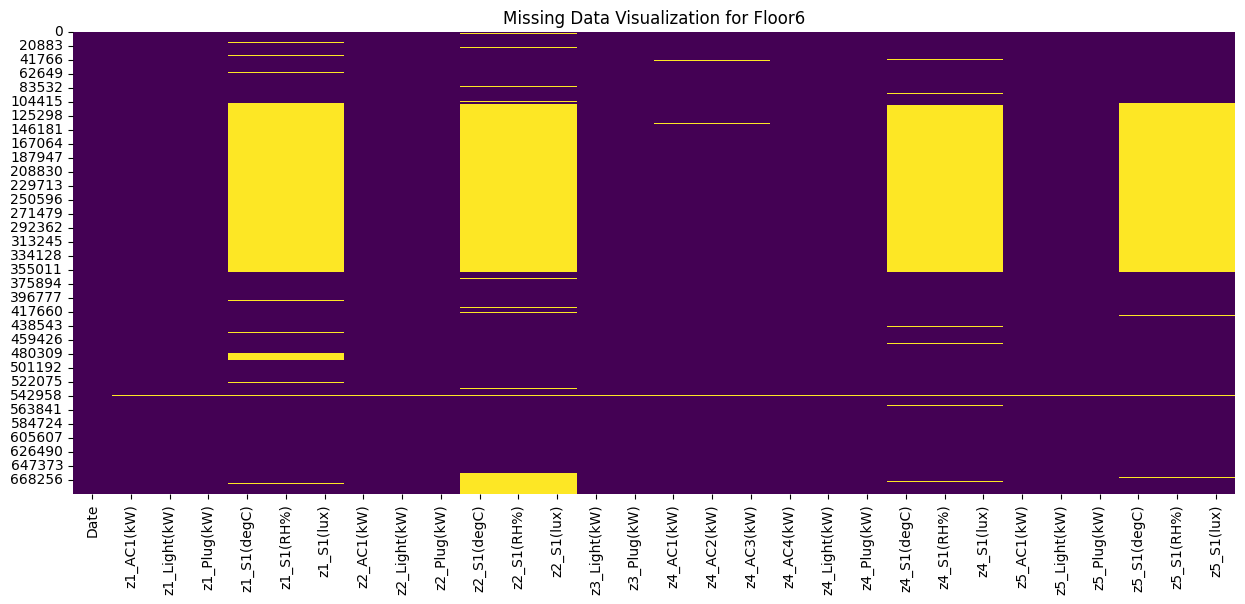

In [1]:
# =============================================================================
# SECTION 1: SETUP AND INITIAL DATA EXPLORATION
# =============================================================================

# --- 1.1 Import Core Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Import machine learning libraries
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler 

# --- 1.2 Load Datasets ---
floor_files = {f'Floor{i}': f'Floor{i}.csv' for i in range(1, 8)}
all_floors = {}
for floor_name, file_name in floor_files.items():
    try:
        all_floors[floor_name] = pd.read_csv(file_name)
        print(f"Successfully loaded {file_name}")
    except FileNotFoundError:
        print(f"Error: {file_name} not found.")

# --- 1.3 Initial Data Inspection ---
TARGET_FLOOR = 'Floor6'
df = all_floors[TARGET_FLOOR].copy()
print(f"\n--- Analyzing {TARGET_FLOOR} ---")
df.info()

# --- 1.4 Visualize Missing Data ---
plt.figure(figsize=(15, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title(f'Missing Data Visualization for {TARGET_FLOOR}')
plt.show()

# PROJECT UTILITIES AND CUSTOM FUNCTIONS

In [2]:
# =============================================================================
# PROJECT UTILITIES AND CUSTOM FUNCTIONS
# =============================================================================

# --- Import Utility and Modeling Libraries ---
# It's good practice to have necessary imports here, although they are also in Section 1.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

# --- Global Seeds for Reproducibility ---
# By setting the random seeds for TensorFlow and NumPy here, we ensure that
# any stochastic process in the entire notebook (like model weight initialization
# or dropout) is deterministic and will produce the same results on every run.
tf.random.set_seed(42)
np.random.seed(42)

# --- Sequence Creation Function ---
def create_sequences(features, target, time_steps):
    """Converts arrays of features and a target into sequences for time-series models."""
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

# --- Custom Keras Layer: Positional Encoding for Transformers ---
class PositionalEncoding(tf.keras.layers.Layer):
    """
    Custom Keras layer to add positional information to the input embeddings.
    This is essential for the Transformer model to understand sequence order.
    """
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.create_positional_encoding(max_len, d_model)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def create_positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                     np.arange(d_model)[np.newaxis, :],
                                     d_model)
        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# --- Reusable Model Evaluation Function (Revised) ---
def evaluate_model(model_name, history, model, X_test, y_test, scaler_target, start_time):
    """Evaluates a trained model, prints metrics, plots results, and returns a results dictionary."""
    
    end_time = time.time()
    training_time = end_time - start_time
    print(f"\n--- Evaluation for {model_name} (Training Time: {training_time:.2f} seconds) ---")
    
    # Plot training & validation loss from the history object
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Scaled Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Make predictions on the test set
    y_pred_scaled = model.predict(X_test)
    
    # Inverse transform predictions and actuals to their original kWh scale
    y_pred = scaler_target.inverse_transform(y_pred_scaled)
    y_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1))

    # Calculate and print key performance metrics
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    mae = mean_absolute_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)
    # **REVISION**: Calculate Coefficient of Variation of the RMSE (CV-RMSE)
    cv_rmse = (rmse / y_actual.mean()) * 100
    
    print("\nPerformance Metrics on Test Set (original kWh scale):")
    print(f"Test RMSE: {rmse:.2f} kWh")
    print(f"Test MAE: {mae:.2f} kWh")
    print(f"Test R-squared: {r2:.4f}")
    print(f"Test CV(RMSE): {cv_rmse:.2f}%") # Print the new metric

    # Plot predictions vs actuals for a clear visual comparison
    plt.figure(figsize=(15, 6))
    plt.plot(y_actual, label='Actual kWh', color='blue', alpha=0.8)
    plt.plot(y_pred, label='Predicted kWh', color='orange', linestyle='--')
    plt.title(f'{model_name} - Test Set Predictions vs Actuals')
    plt.xlabel('Time Step (Hour)')
    plt.ylabel('Total kWh')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Store and return results for final comparison
    results = {
        'Model': model_name,
        'Test RMSE (kWh)': rmse,
        'Test MAE (kWh)': mae,
        'Test R-squared': r2,
        'Test CV(RMSE) (%)': cv_rmse, # Add the new metric to the results table
        'Training Time (s)': training_time
    }
    return results

# SECTION 2: DATA CLEANING AND PREPROCESSING

Missing values before imputation: 27558
Missing values after imputation: 0

Training set shape: (9168, 1)
Testing set shape: (2318, 1)

Identified outliers will be capped at: 112.28 kWh
Outlier handling complete.


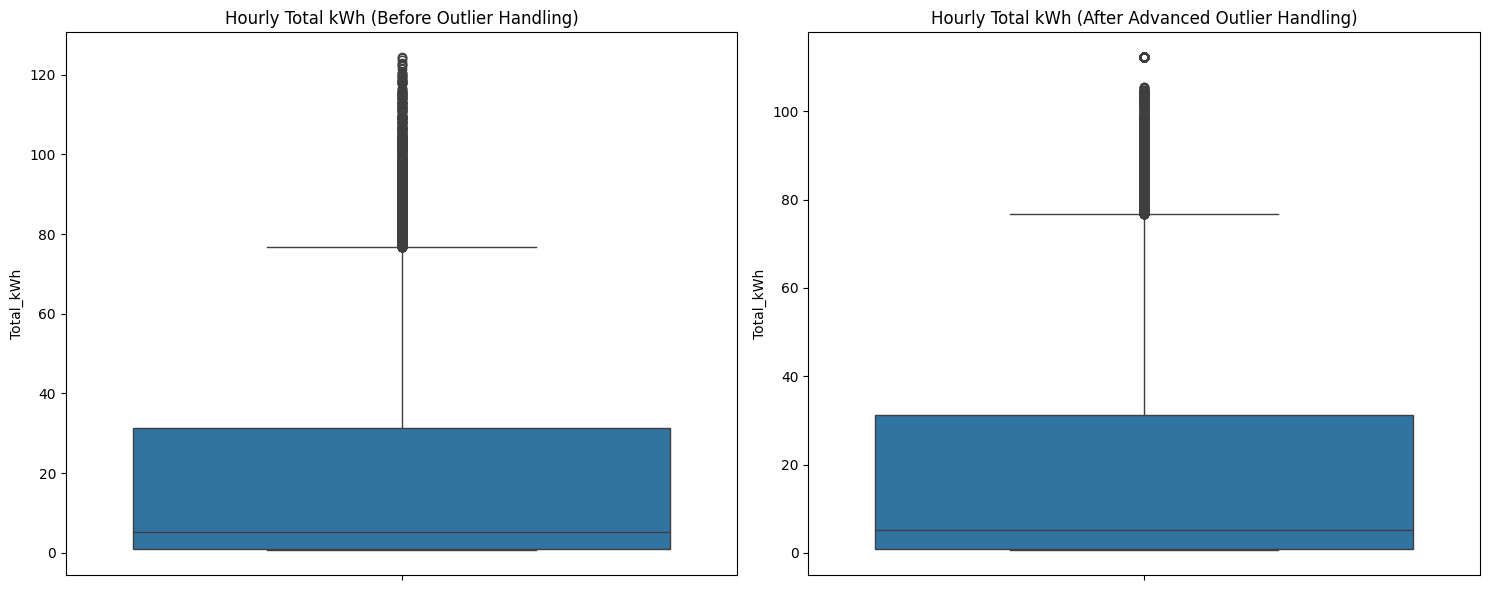

In [3]:
# =============================================================================
# SECTION 2: DATA CLEANING AND PREPROCESSING
# =============================================================================

# --- 2.1 Standardize Date Column and Set as Index ---
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# --- 2.2 Filter for Relevant Columns (Energy Consumption) ---
energy_columns = [col for col in df.columns if col.endswith('(kW)')]
df_energy = df[energy_columns].copy() # Use .copy() to avoid SettingWithCopyWarning

# --- 2.3 Handle Missing Values ---
print(f"Missing values before imputation: {df_energy.isna().sum().sum()}")
# Using ffill and bfill is a sound choice for time-series data.
df_energy.ffill(inplace=True)
df_energy.bfill(inplace=True)
print(f"Missing values after imputation: {df_energy.isna().sum().sum()}")

# --- 2.4 Create Target Variable (Total Energy Consumption) ---
df_energy['Total_kW'] = df_energy.sum(axis=1)

# --- 2.5 Resample to Hourly Data ---
# **CORRECTION**: To correctly convert power (kW) to energy (kWh) for one-hour intervals,
# we must take the mean of the power readings over that hour.
df_hourly = df_energy[['Total_kW']].resample('h').mean()
df_hourly.rename(columns={'Total_kW': 'Total_kWh'}, inplace=True)

# --- 2.6 Split Data into Training and Testing Sets ---
# It is crucial to split the data *before* applying outlier detection and scaling
# to prevent data leakage from the test set into the training process.
split_date = '2019-07-18'
train_df = df_hourly.loc[df_hourly.index < split_date].copy()
test_df = df_hourly.loc[df_hourly.index >= split_date].copy()

print(f"\nTraining set shape: {train_df.shape}")
print(f"Testing set shape: {test_df.shape}")

# --- 2.7 Advanced Outlier Detection with Isolation Forest ---
# We fit the outlier detector ONLY on the training data to learn the normal patterns.
# The 'random_state' parameter ensures this stochastic process is reproducible.
iso_forest = IsolationForest(contamination=0.01, random_state=42)
train_df['outlier'] = iso_forest.fit_predict(train_df[['Total_kWh']])

# We then use the FITTED model to predict outliers on the test set.
test_df['outlier'] = iso_forest.predict(test_df[['Total_kWh']])

# Define the capping value based on the 99.5th percentile of the TRAINING data.
capping_value = train_df['Total_kWh'].quantile(0.995)
print(f"\nIdentified outliers will be capped at: {capping_value:.2f} kWh")

# Apply the capping to both training and testing sets
train_df['Total_kWh'] = train_df.apply(lambda row: capping_value if row['outlier'] == -1 else row['Total_kWh'], axis=1)
test_df['Total_kWh'] = test_df.apply(lambda row: capping_value if row['outlier'] == -1 else row['Total_kWh'], axis=1)

# Drop the outlier column as it's no longer needed
train_df.drop(columns=['outlier'], inplace=True)
test_df.drop(columns=['outlier'], inplace=True)

print("Outlier handling complete.")

# Visualize the effect of outlier capping
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=df_hourly['Total_kWh']) # Original data
plt.title('Hourly Total kWh (Before Outlier Handling)')

plt.subplot(1, 2, 2)
sns.boxplot(y=pd.concat([train_df, test_df])['Total_kWh']) # Capped data
plt.title('Hourly Total kWh (After Advanced Outlier Handling)')
plt.tight_layout()
plt.show()

# SECTION 3: FEATURE ENGINEERING AND EXPLORATORY DATA ANALYSIS (EDA)

Added temporal features (Hour, DayOfWeek, etc.).
Added 'IsHoliday' feature.
Found 384 holiday hours in the training set.
Found 72 holiday hours in the testing set.
Applied cyclical encoding to time-based features.


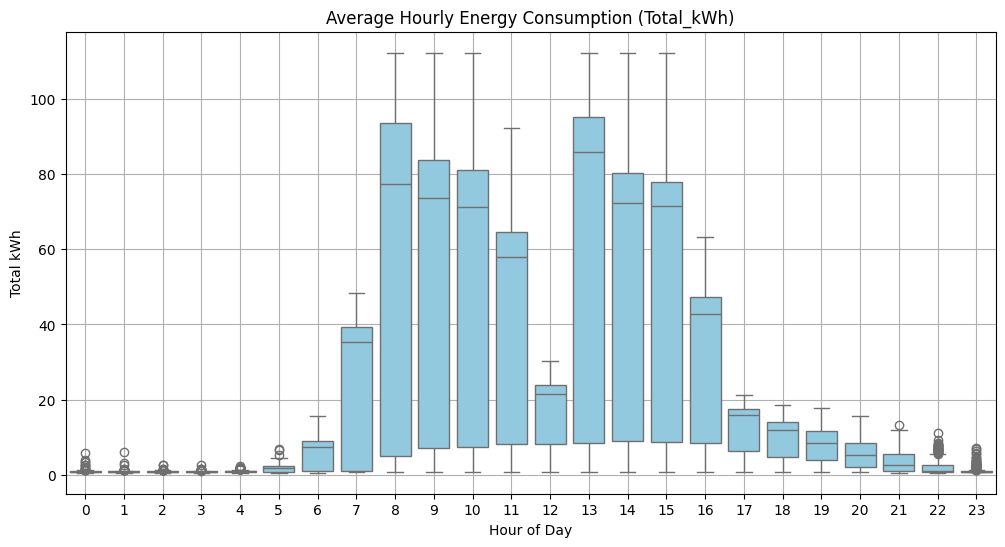

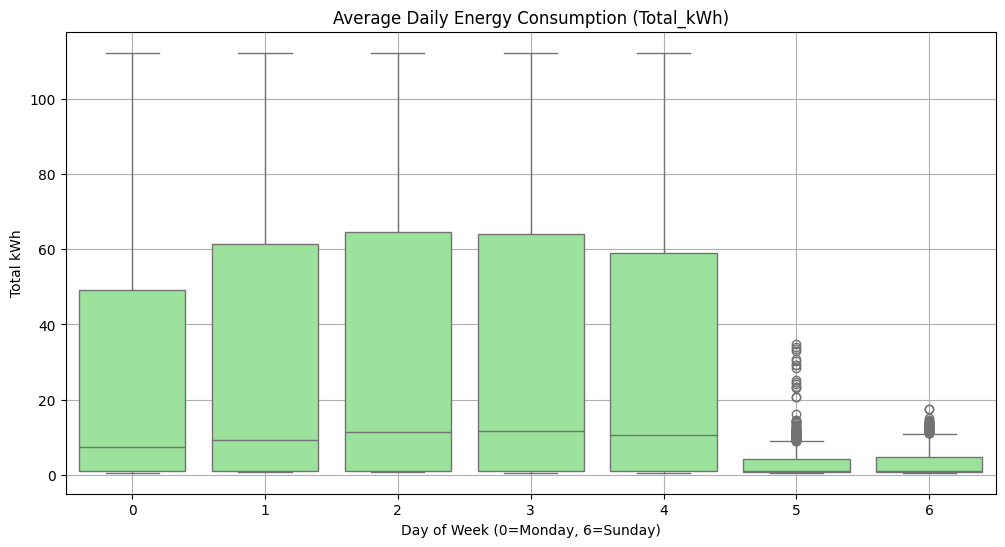

In [4]:
# =============================================================================
# SECTION 3: FEATURE ENGINEERING AND EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================

# --- 3.1 Create Time-Based Features ---
# We create features from the datetime index to capture temporal patterns.

def create_features(df):
    """Creates time series features from a datetime index."""
    df = df.copy()
    df['Hour'] = df.index.hour
    df['DayOfWeek'] = df.index.dayofweek  # Monday=0, Sunday=6
    df['Month'] = df.index.month
    df['WeekOfYear'] = df.index.isocalendar().week.astype(int) # Ensure integer type
    df['IsWeekend'] = (df.index.dayofweek >= 5).astype(int)
    return df

train_df = create_features(train_df)
test_df = create_features(test_df)

print("Added temporal features (Hour, DayOfWeek, etc.).")

# --- 3.2 Create Holiday Feature ---
# Incorporating known holidays can significantly improve model accuracy.
holidays = pd.to_datetime([
    '2018-07-27', '2018-07-30', '2018-08-13', '2018-10-23', '2018-12-05',
    '2018-12-10', '2018-12-31', '2019-01-01', '2019-02-19', '2019-04-08',
    '2019-04-13', '2019-04-14', '2019-04-15', '2019-05-06', '2019-05-18',
    '2019-07-16', '2019-07-28', '2019-08-12', '2019-10-14', '2019-10-23',
    '2019-12-05', '2019-12-10', '2019-12-31'
])

# We use .normalize() to get the date at midnight and then use .isin()
# This keeps the index as a DatetimeIndex, which has the .isin() method.
train_df['IsHoliday'] = train_df.index.normalize().isin(holidays).astype(int)
test_df['IsHoliday'] = test_df.index.normalize().isin(holidays).astype(int)

print("Added 'IsHoliday' feature.")
print(f"Found {train_df['IsHoliday'].sum()} holiday hours in the training set.")
print(f"Found {test_df['IsHoliday'].sum()} holiday hours in the testing set.")


# --- 3.3 Cyclical Feature Encoding ---
# This helps models understand the cyclical nature of time (e.g., December is close to January).
def encode_cyclical(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df

train_df = encode_cyclical(train_df, 'Hour', 24)
train_df = encode_cyclical(train_df, 'DayOfWeek', 7)
train_df = encode_cyclical(train_df, 'Month', 12)
train_df = encode_cyclical(train_df, 'WeekOfYear', 52)

test_df = encode_cyclical(test_df, 'Hour', 24)
test_df = encode_cyclical(test_df, 'DayOfWeek', 7)
test_df = encode_cyclical(test_df, 'Month', 12)
test_df = encode_cyclical(test_df, 'WeekOfYear', 52)

print("Applied cyclical encoding to time-based features.")

# --- 3.4 Exploratory Data Analysis (EDA) ---
# Visualize the relationship between features and the target variable.

# Plot 1: Average kWh by Hour of the Day
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df, x='Hour', y='Total_kWh', color='skyblue')
plt.title('Average Hourly Energy Consumption (Total_kWh)')
plt.xlabel('Hour of Day')
plt.ylabel('Total kWh')
plt.grid(True)
plt.show()

# Plot 2: Average kWh by Day of the Week
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df, x='DayOfWeek', y='Total_kWh', color='lightgreen')
plt.title('Average Daily Energy Consumption (Total_kWh)')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Total kWh')
plt.grid(True)
plt.show()

# SECTION 4: PREPARING DATA FOR TIME-SERIES MODELS

In [5]:
# =============================================================================
# SECTION 4: PREPARING DATA FOR TIME-SERIES MODELS
# =============================================================================

# --- 4.1 Isolate Features and Target ---
# First, we explicitly define which columns are our model's inputs (features) and
# which one is the output we want to predict (target).

feature_columns = [
    'Hour_sin', 'Hour_cos',
    'DayOfWeek_sin', 'DayOfWeek_cos',
    'Month_sin', 'Month_cos',
    'WeekOfYear_sin', 'WeekOfYear_cos',
    'IsWeekend', 'IsHoliday',
    'Total_kWh' # Past kWh is an input feature.
]
target_column = 'Total_kWh'

X_train_df = train_df[feature_columns]
y_train_df = train_df[[target_column]]

X_test_df = test_df[feature_columns]
y_test_df = test_df[[target_column]]

# --- 4.2 Feature Scaling (Corrected Workflow) ---
# This is the corrected, leak-proof way to scale data.
# We use two separate scalers and fit them ONLY on the training data.

scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Fit and transform the training data
X_train_scaled = scaler_features.fit_transform(X_train_df)
y_train_scaled = scaler_target.fit_transform(y_train_df)

# Transform the test data using the scalers that were FITTED on the training data
X_test_scaled = scaler_features.transform(X_test_df)
y_test_scaled = scaler_target.transform(y_test_df)

print("Data has been scaled correctly without leakage.")

# --- 4.3 Create Sequences for One-Step-Ahead Forecasting ---
# This function is now defined in the "Utilities" section.

# Define the look-back window
TIME_STEPS = 24

# Create the sequences from the scaled numpy arrays and name them with "_1step" for clarity
X_train_1step, y_train_1step = create_sequences(X_train_scaled, y_train_scaled.ravel(), TIME_STEPS)
X_test_1step, y_test_1step = create_sequences(X_test_scaled, y_test_scaled.ravel(), TIME_STEPS)


print(f"\nCreated sequences for one-step-ahead forecasting with a look-back window of {TIME_STEPS} hours.")
print(f'X_train_1step shape: {X_train_1step.shape}')
print(f'y_train_1step shape: {y_train_1step.shape}')
print(f'X_test_1step shape: {X_test_1step.shape}')
print(f'y_test_1step shape: {y_test_1step.shape}')

Data has been scaled correctly without leakage.

Created sequences for one-step-ahead forecasting with a look-back window of 24 hours.
X_train_1step shape: (9144, 24, 11)
y_train_1step shape: (9144,)
X_test_1step shape: (2294, 24, 11)
y_test_1step shape: (2294,)


# SECTION 5: MODEL 1 - BASELINE LSTM (ONE-STEP-AHEAD)

Trial 10 Complete [00h 02m 04s]
val_loss: 0.002057675737887621

Best val_loss So Far: 0.0013261488638818264
Total elapsed time: 00h 18m 02s

--- Optimal Hyperparameters for LSTM Found ---
Layer 1 Units: 200
Layer 2 Units: 100
Dropout Rate: 0.30
Learning Rate: 0.001


--- Training the Best Baseline LSTM Model ---
Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0342 - val_loss: 0.0196 - learning_rate: 0.0010
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0204 - val_loss: 0.0169 - learning_rate: 0.0010
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0186 - val_loss: 0.0122 - learning_rate: 0.0010
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0146 - val_loss: 0.0124 - learning_rate: 0.0010
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0125 - val_loss: 0.0118 - learning_rate: 0.0010
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0103 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 7/100
14

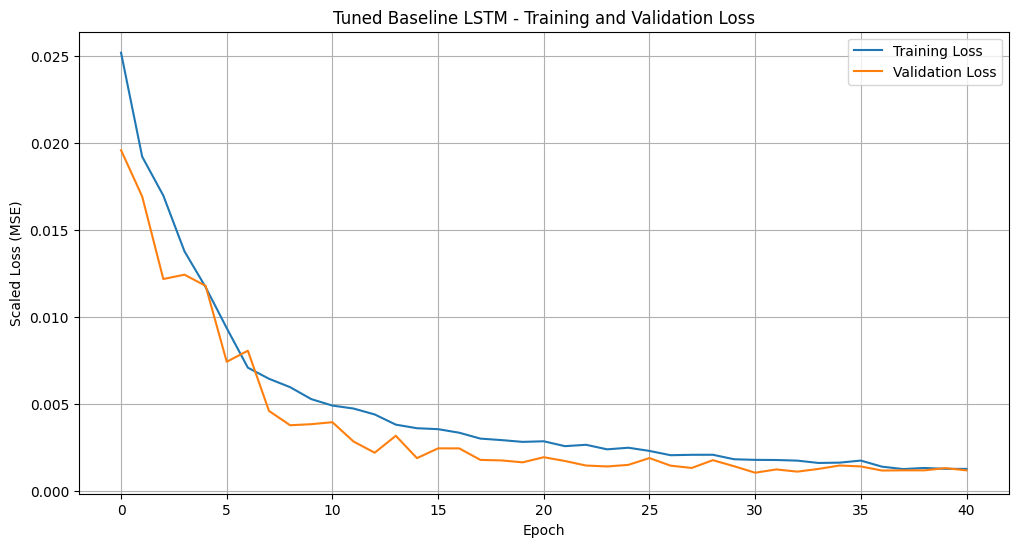

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step

Performance Metrics on Test Set (original kWh scale):
Test RMSE: 3.62 kWh
Test MAE: 2.17 kWh
Test R-squared: 0.9862
Test CV(RMSE): 16.52%


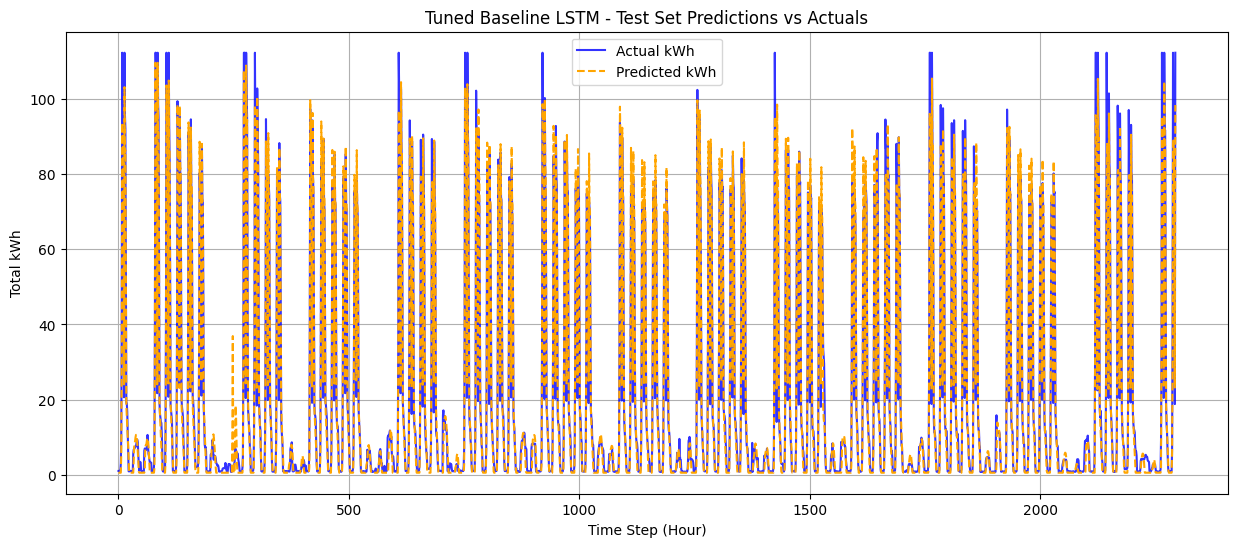

In [6]:
# =============================================================================
# SECTION 5: MODEL 1 - HYPERPARAMETER TUNING FOR BASELINE LSTM
# =============================================================================

# --- 5.1 Import Modeling and Utility Libraries ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import keras_tuner as kt
import time

# Optional: Set a seed for reproducibility (already set in Utilities, but safe to keep)
tf.random.set_seed(42)
np.random.seed(42)

# --- 5.2 Define the LSTM HyperModel for KerasTuner ---
class LSTMHyperModel(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        """Builds a tunable LSTM model."""
        model = Sequential(name='Baseline_LSTM')
        
        # Tune the number of units in the first LSTM layer
        hp_units_1 = hp.Int('units_1', min_value=50, max_value=200, step=50)
        # Tune the number of units in the second LSTM layer
        hp_units_2 = hp.Int('units_2', min_value=50, max_value=200, step=50)
        # Tune the dropout rate
        hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
        # Tune the learning rate
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])

        model.add(LSTM(units=hp_units_1, return_sequences=True, input_shape=self.input_shape))
        model.add(Dropout(hp_dropout))
        model.add(LSTM(units=hp_units_2, return_sequences=False))
        model.add(Dropout(hp_dropout))
        
        # **CORRECTION**: Add 'relu' activation to ensure all predictions are non-negative.
        model.add(Dense(1, activation='relu'))
        
        model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mean_squared_error')
        return model

# --- 5.3 Run the Bayesian Optimization Search ---
input_shape = (X_train_1step.shape[1], X_train_1step.shape[2])
hypermodel_lstm = LSTMHyperModel(input_shape)

tuner_lstm = kt.BayesianOptimization(
    hypermodel_lstm,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    # **REVISION**: Changed project name to ensure a fresh tuning session for the new architecture.
    project_name='lstm_tuning_relu',
    overwrite=True,
    # **REPRODUCIBILITY**: Add a seed to the tuner to ensure the search is deterministic.
    seed=42
)

print("\n--- Starting Hyperparameter Search for Baseline LSTM Model ---")
tuner_lstm.search(
    X_train_1step, y_train_1step,
    epochs=25,
    batch_size=64,
    validation_data=(X_test_1step, y_test_1step),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)

# --- 5.4 Train the Best LSTM Model and Evaluate ---
best_hps_lstm = tuner_lstm.get_best_hyperparameters(num_trials=1)[0]
print(f"""
--- Optimal Hyperparameters for LSTM Found ---
Layer 1 Units: {best_hps_lstm.get('units_1')}
Layer 2 Units: {best_hps_lstm.get('units_2')}
Dropout Rate: {best_hps_lstm.get('dropout'):.2f}
Learning Rate: {best_hps_lstm.get('learning_rate')}
""")

# Build the best model with the optimal hyperparameters
best_lstm_model = tuner_lstm.hypermodel.build(best_hps_lstm)

# Train the best model fully
print("\n--- Training the Best Baseline LSTM Model ---")
start_time = time.time()
history_lstm = best_lstm_model.fit(
    X_train_1step, y_train_1step,
    epochs=100,
    batch_size=64,
    validation_data=(X_test_1step, y_test_1step),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)],
    verbose=1
)

# Evaluate the final, tuned model
# We keep the variable name 'results_lstm' so Section 7 can find it.
results_lstm = evaluate_model(
    "Tuned Baseline LSTM", 
    history_lstm, 
    best_lstm_model, 
    X_test_1step, 
    y_test_1step, 
    scaler_target, 
    start_time
)

# SECTION 6: MODEL 2 - HYBRID CNN-LSTM

Trial 10 Complete [00h 02m 32s]
val_loss: 0.001168352086097002

Best val_loss So Far: 0.00113830273039639
Total elapsed time: 00h 23m 15s

--- Optimal Hyperparameters for CNN-LSTM Found ---
CNN Filters: 64
LSTM Units 1: 150
LSTM Units 2: 50
Dropout Rate: 0.20
Learning Rate: 0.001


--- Training the Best CNN-LSTM Model ---
Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 0.0344 - val_loss: 0.0171 - learning_rate: 0.0010
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0183 - val_loss: 0.0164 - learning_rate: 0.0010
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0154 - val_loss: 0.0100 - learning_rate: 0.0010
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0113 - val_loss: 0.0075 - learning_rate: 0.0010
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0083 - val_loss: 0.0072 - learning_rate: 0.0010
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0068 - val_loss: 0.0043 - learning_rate: 0.0010
Epoc

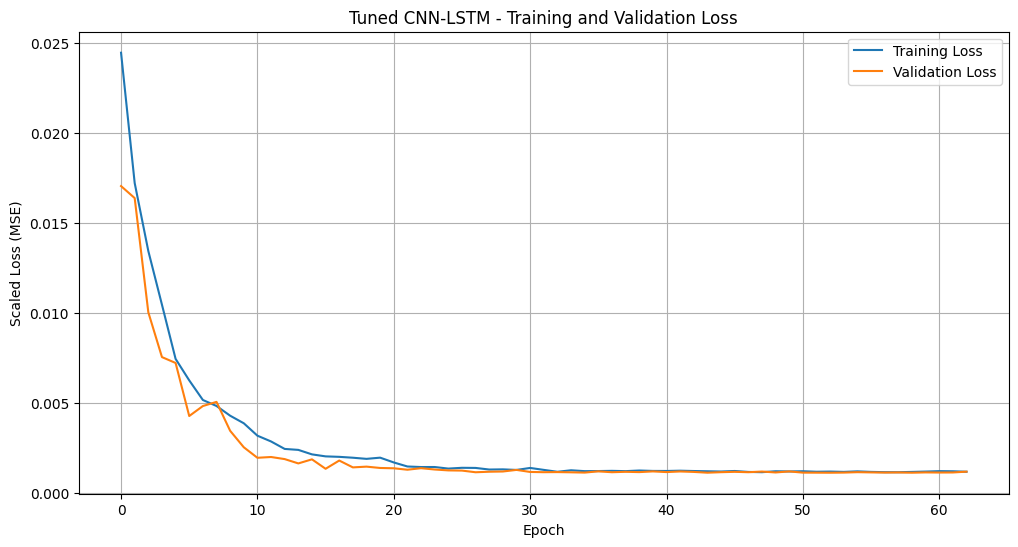

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step

Performance Metrics on Test Set (original kWh scale):
Test RMSE: 3.71 kWh
Test MAE: 2.18 kWh
Test R-squared: 0.9855
Test CV(RMSE): 16.94%


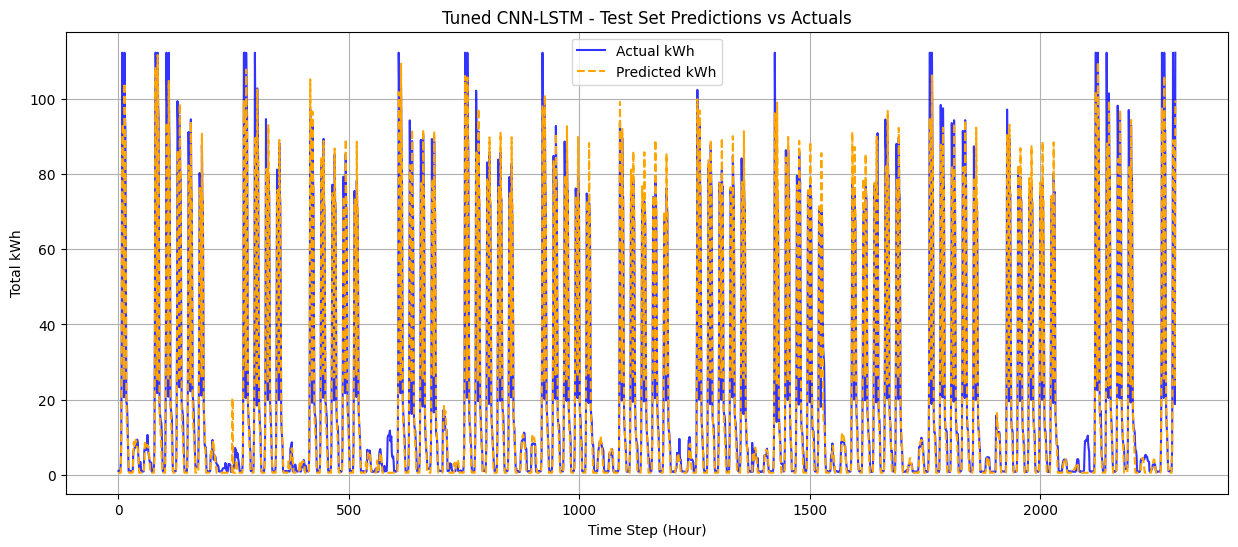

In [9]:
# =============================================================================
# SECTION 6: MODEL 2 - HYPERPARAMETER TUNING FOR CNN-LSTM
# =============================================================================

# --- 6.1 Import Additional Libraries ---
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
import keras_tuner as kt

# --- 6.2 Define the CNN-LSTM HyperModel for KerasTuner (Definitive Version) ---
class CNNLSTMHyperModel(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        """Builds a tunable and robust CNN-LSTM model."""
        model = Sequential(name='CNN_LSTM')

        # Tune the number of filters in the Conv1D layer
        hp_filters = hp.Int('filters', min_value=64, max_value=128, step=32)
        # Tune the number of units in the LSTM layers
        hp_lstm_units_1 = hp.Int('lstm_units_1', min_value=100, max_value=200, step=50)
        hp_lstm_units_2 = hp.Int('lstm_units_2', min_value=50, max_value=150, step=50)
        # Tune the dropout rate
        hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.4, step=0.1)
        # Tune the learning rate
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4])

        # **REVISION**: The Conv1D layer now uses 'padding=same' and is NOT followed by MaxPooling.
        model.add(Conv1D(filters=hp_filters, kernel_size=3, activation='relu', 
                         input_shape=self.input_shape, padding='same'))
        
        # **REVISION**: Added a second LSTM layer to increase model capacity.
        model.add(LSTM(units=hp_lstm_units_1, return_sequences=True))
        model.add(Dropout(hp_dropout))
        model.add(LSTM(units=hp_lstm_units_2, return_sequences=False))
        model.add(Dropout(hp_dropout))
        
        # **REVISION**: Added a bias_initializer to the final Dense layer.
        model.add(Dense(1, activation='relu', 
                      bias_initializer=tf.keras.initializers.Constant(0.1)))
        
        model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mean_squared_error')
        return model

# --- 6.3 Run the Bayesian Optimization Search ---
hypermodel_cnn_lstm = CNNLSTMHyperModel(input_shape)

tuner_cnn_lstm = kt.BayesianOptimization(
    hypermodel_cnn_lstm,
    objective='val_loss',
    max_trials=10,  # **CORRECTION**: Reverted to 10 trials for consistency.
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='cnn_lstm_tuning_relu_final', # New project name
    overwrite=True,
    seed=42
)

print("\n--- Starting Hyperparameter Search for CNN-LSTM Model ---")
tuner_cnn_lstm.search(
    X_train_1step, y_train_1step,
    epochs=25,  # **CORRECTION**: Reverted to 25 epochs for consistency.
    batch_size=64,
    validation_data=(X_test_1step, y_test_1step),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)

# --- 6.4 Train the Best CNN-LSTM Model and Evaluate ---
best_hps_cnn_lstm = tuner_cnn_lstm.get_best_hyperparameters(num_trials=1)[0]
print(f"""
--- Optimal Hyperparameters for CNN-LSTM Found ---
CNN Filters: {best_hps_cnn_lstm.get('filters')}
LSTM Units 1: {best_hps_cnn_lstm.get('lstm_units_1')}
LSTM Units 2: {best_hps_cnn_lstm.get('lstm_units_2')}
Dropout Rate: {best_hps_cnn_lstm.get('dropout'):.2f}
Learning Rate: {best_hps_cnn_lstm.get('learning_rate')}
""")

# Rebuild the best model to ensure we can train it for a longer duration
best_cnn_lstm_model = tuner_cnn_lstm.hypermodel.build(best_hps_cnn_lstm)

# Train the best model fully
print("\n--- Training the Best CNN-LSTM Model ---")
start_time = time.time()
history_cnn_lstm = best_cnn_lstm_model.fit(
    X_train_1step, y_train_1step,
    epochs=100,
    batch_size=64,
    validation_data=(X_test_1step, y_test_1step),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)],
    verbose=1
)

# Evaluate the final, tuned model
# We keep the variable name 'results_cnn_lstm' so Section 7 can find it.
results_cnn_lstm = evaluate_model(
    "Tuned CNN-LSTM", 
    history_cnn_lstm, 
    best_cnn_lstm_model, 
    X_test_1step, 
    y_test_1step, 
    scaler_target, 
    start_time
)

# SECTION 7: MODEL 3 - TRANSFORMER AND FINAL COMPARISON (ONE-STEP-AHEAD)

Trial 10 Complete [00h 05m 04s]
val_loss: 0.0022696342784911394

Best val_loss So Far: 0.0013020673068240285
Total elapsed time: 00h 39m 02s

--- Optimal Hyperparameters for Transformer Found ---
Model Dimension (d_model): 128
Number of Attention Heads: 2
Feed-Forward Dimension: 128
Number of Transformer Blocks: 2
Dropout Rate: 0.10
Learning Rate: 0.0005


--- Training the Best Transformer Model ---
Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 43s 228ms/step - loss: 0.1533 - val_loss: 0.0727 - learning_rate: 5.0000e-04
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.0487 - val_loss: 0.0143 - learning_rate: 5.0000e-04
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.0136 - val_loss: 0.0055 - learning_rate: 5.0000e-04
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 0.0057 - val_loss: 0.0037 - learning_rate: 5.0000e-04
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - loss: 0.0040 - val_loss: 0.0044 - learning_rate: 5.0000e-04
Epoch 6/100

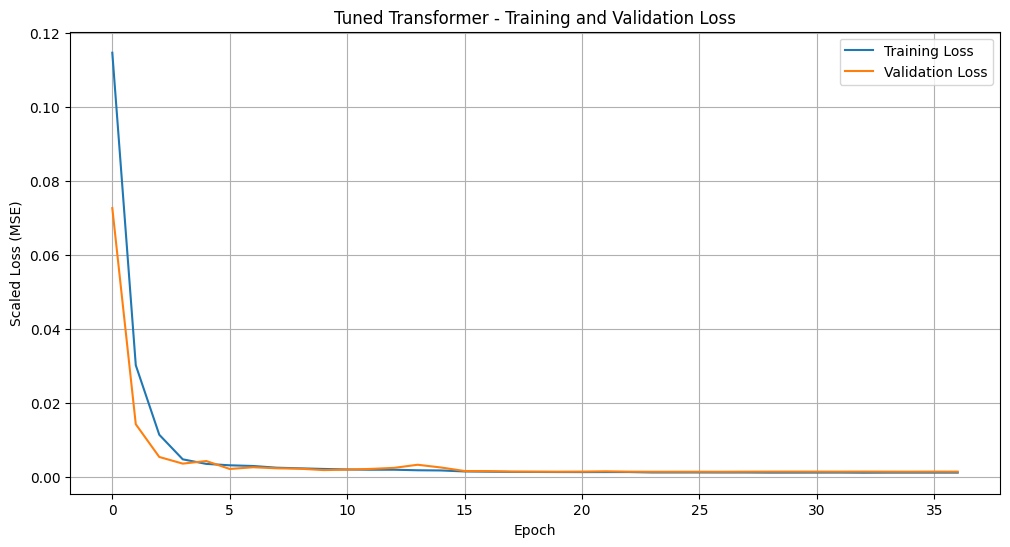

72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step

Performance Metrics on Test Set (original kWh scale):
Test RMSE: 4.29 kWh
Test MAE: 2.42 kWh
Test R-squared: 0.9805
Test CV(RMSE): 19.61%


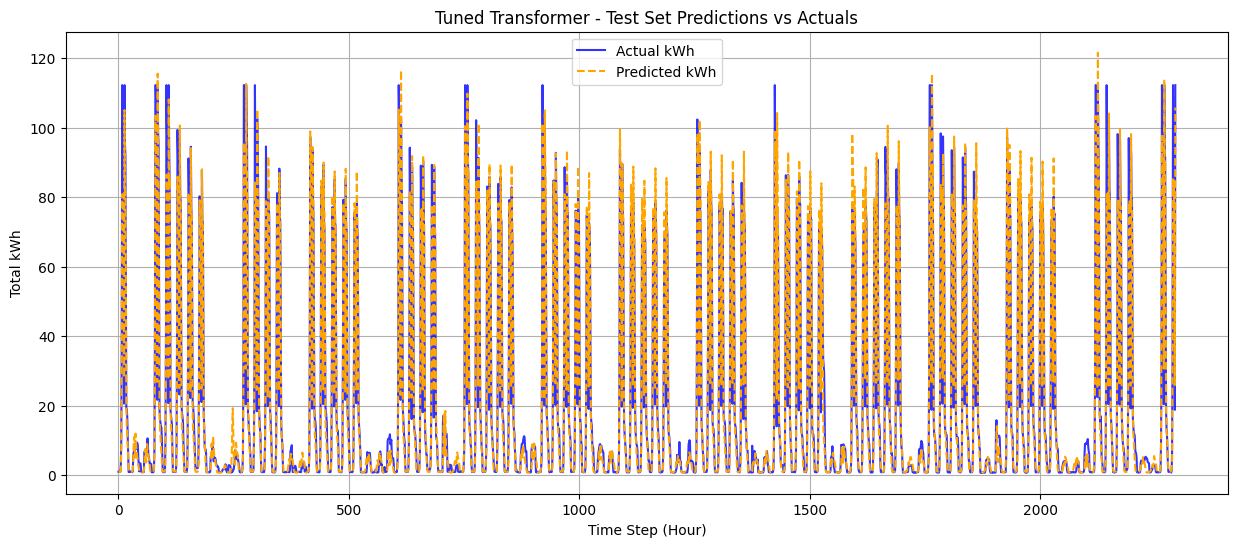



--- Final One-Step-Ahead Model Comparison ---
                     Test RMSE (kWh)  Test MAE (kWh)  Test R-squared  \
Model                                                                  
Tuned Baseline LSTM         3.618433        2.166593        0.986188   
Tuned CNN-LSTM              3.710437        2.178993        0.985477   
Tuned Transformer           4.294481        2.417536        0.980545   

                     Test CV(RMSE) (%)  Training Time (s)  
Model                                                      
Tuned Baseline LSTM          16.524152         202.974711  
Tuned CNN-LSTM               16.944303         314.220177  
Tuned Transformer            19.611434         422.200847  


In [10]:
# =============================================================================
# SECTION 7: MODEL 3 - HYPERPARAMETER TUNING FOR TRANSFORMER (REVISED)
# =============================================================================

# --- 7.1 Import Additional Libraries ---
from tensorflow.keras.layers import Input, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add
from tensorflow.keras.models import Model
import keras_tuner as kt
import time

# --- 7.2 Define the Transformer HyperModel with a Robust Non-Negative Output ---
# (PositionalEncoding class must be defined in a previous cell for this to work)
class TransformerHyperModel(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        """Builds a tunable Transformer model with a Softplus activation on the output."""
        
        # Define the search space for hyperparameters
        d_model = hp.Int('d_model', min_value=32, max_value=128, step=32)
        num_heads = hp.Int('num_heads', min_value=2, max_value=8, step=2)
        ff_dim = hp.Int('ff_dim', min_value=64, max_value=256, step=64)
        num_transformer_blocks = hp.Int('num_blocks', min_value=1, max_value=3, step=1)
        dropout_rate = hp.Float('dropout', min_value=0.1, max_value=0.4, step=0.1)
        learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])

        inputs = Input(shape=self.input_shape)
        x = Dense(d_model)(inputs)
        x = PositionalEncoding(d_model)(x)
        
        for _ in range(num_transformer_blocks):
            attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
            attention_output = Dropout(dropout_rate)(attention_output)
            x = Add()([x, attention_output])
            x = LayerNormalization(epsilon=1e-6)(x)
            
            ffn_output = Dense(ff_dim, activation="relu")(x)
            ffn_output = Dense(d_model)(ffn_output)
            ffn_output = Dropout(dropout_rate)(ffn_output)
            x = Add()([x, ffn_output])
            x = LayerNormalization(epsilon=1e-6)(x)
            
        x = GlobalAveragePooling1D()(x)
        x = Dropout(dropout_rate)(x)
        
        # **CORRECTION**: Use 'softplus' activation for a smooth, non-negative output
        # that is less prone to the "dying neuron" problem.
        outputs = Dense(1, activation='softplus')(x)
        
        model = Model(inputs=inputs, outputs=outputs, name='Transformer')
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
        return model

# --- 7.3 Run the Bayesian Optimization Search ---
hypermodel_transformer = TransformerHyperModel(input_shape)

tuner_transformer = kt.BayesianOptimization(
    hypermodel_transformer,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='transformer_tuning_softplus', # Use a new project name
    overwrite=True,
    # **REPRODUCIBILITY**: Add a seed to the tuner to ensure the search is deterministic.
    seed=42
)

print("\n--- Starting Hyperparameter Search for Transformer Model ---")
tuner_transformer.search(
    X_train_1step, y_train_1step,
    epochs=25,
    batch_size=64,
    validation_data=(X_test_1step, y_test_1step),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)

# --- 7.4 Train the Best Model and Evaluate ---
best_hps_transformer = tuner_transformer.get_best_hyperparameters(num_trials=1)[0]
print(f"""
--- Optimal Hyperparameters for Transformer Found ---
Model Dimension (d_model): {best_hps_transformer.get('d_model')}
Number of Attention Heads: {best_hps_transformer.get('num_heads')}
Feed-Forward Dimension: {best_hps_transformer.get('ff_dim')}
Number of Transformer Blocks: {best_hps_transformer.get('num_blocks')}
Dropout Rate: {best_hps_transformer.get('dropout'):.2f}
Learning Rate: {best_hps_transformer.get('learning_rate')}
""")

# Build the best model
best_transformer_model = tuner_transformer.hypermodel.build(best_hps_transformer)

# Train the best model fully
print("\n--- Training the Best Transformer Model ---")
start_time = time.time()
history_transformer = best_transformer_model.fit(
    X_train_1step, y_train_1step,
    epochs=100,
    batch_size=64,
    validation_data=(X_test_1step, y_test_1step),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)],
    verbose=1
)

# Evaluate the final, tuned model
results_transformer = evaluate_model(
    "Tuned Transformer", 
    history_transformer, 
    best_transformer_model, 
    X_test_1step, 
    y_test_1step, 
    scaler_target, 
    start_time
)

# --- 7.5 Final Model Comparison ---
all_results = [results_lstm, results_cnn_lstm, results_transformer]
results_df = pd.DataFrame(all_results).set_index('Model')
print("\n\n--- Final One-Step-Ahead Model Comparison ---")
print(results_df.sort_values(by='Test RMSE (kWh)'))

# SECTION 8: MULTI-HORIZON FORECASTING WITH THE CHAMPION MODEL (TUNED LSTM)

Created multi-horizon sequences for the champion model.


/Users/soheil/anaconda3/envs/tf_m1/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Multi_Horizon_Tuned_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 200)        │       169,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 24, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 150)            │       210,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │           755 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 380,955 (1.45 MB)

 Trainable params: 380,955 (1.45 MB)

 Non-trainable params: 0 (0.00 B)


--- Training the Champion Multi-Horizon Model ---
Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - loss: 0.0401 - val_loss: 0.0197 - learning_rate: 0.0010
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0209 - val_loss: 0.0142 - learning_rate: 0.0010
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0175 - val_loss: 0.0111 - learning_rate: 0.0010
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0143 - val_loss: 0.0100 - learning_rate: 0.0010
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 0.0124 - val_loss: 0.0100 - learning_rate: 0.0010
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0119 - val_loss: 0.0089 - learning_rate: 0.0010
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0109 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 8/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0102 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 9/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/st

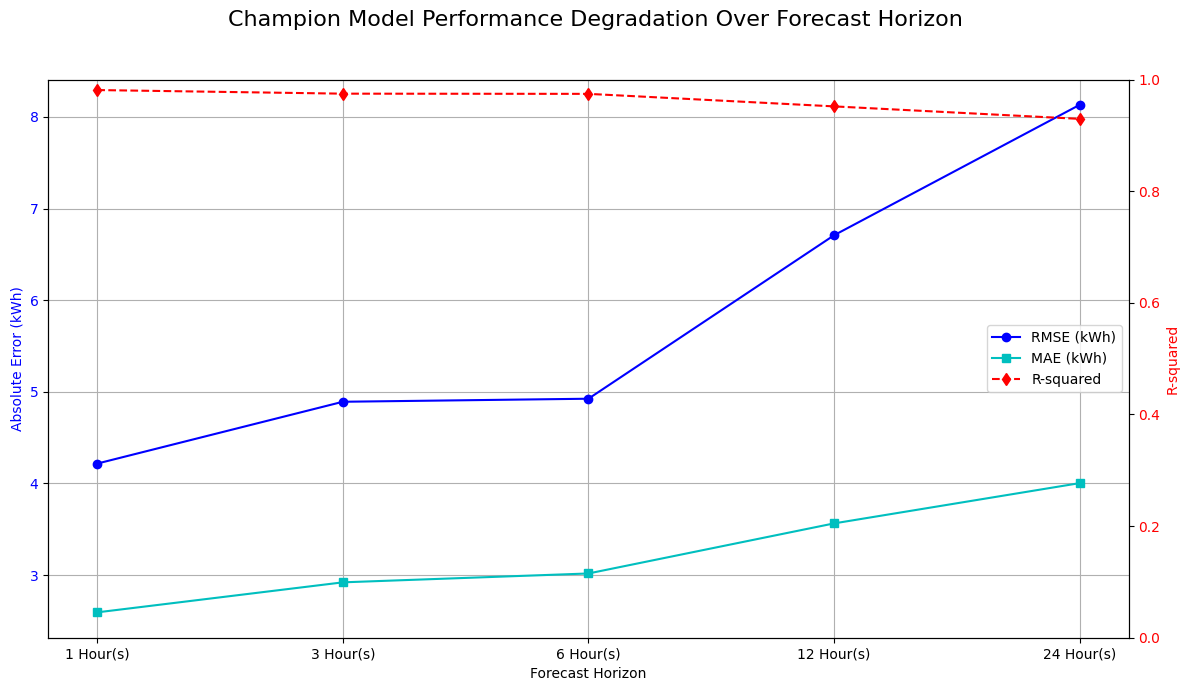


--- Granular Error Analysis by Hour of Day ---


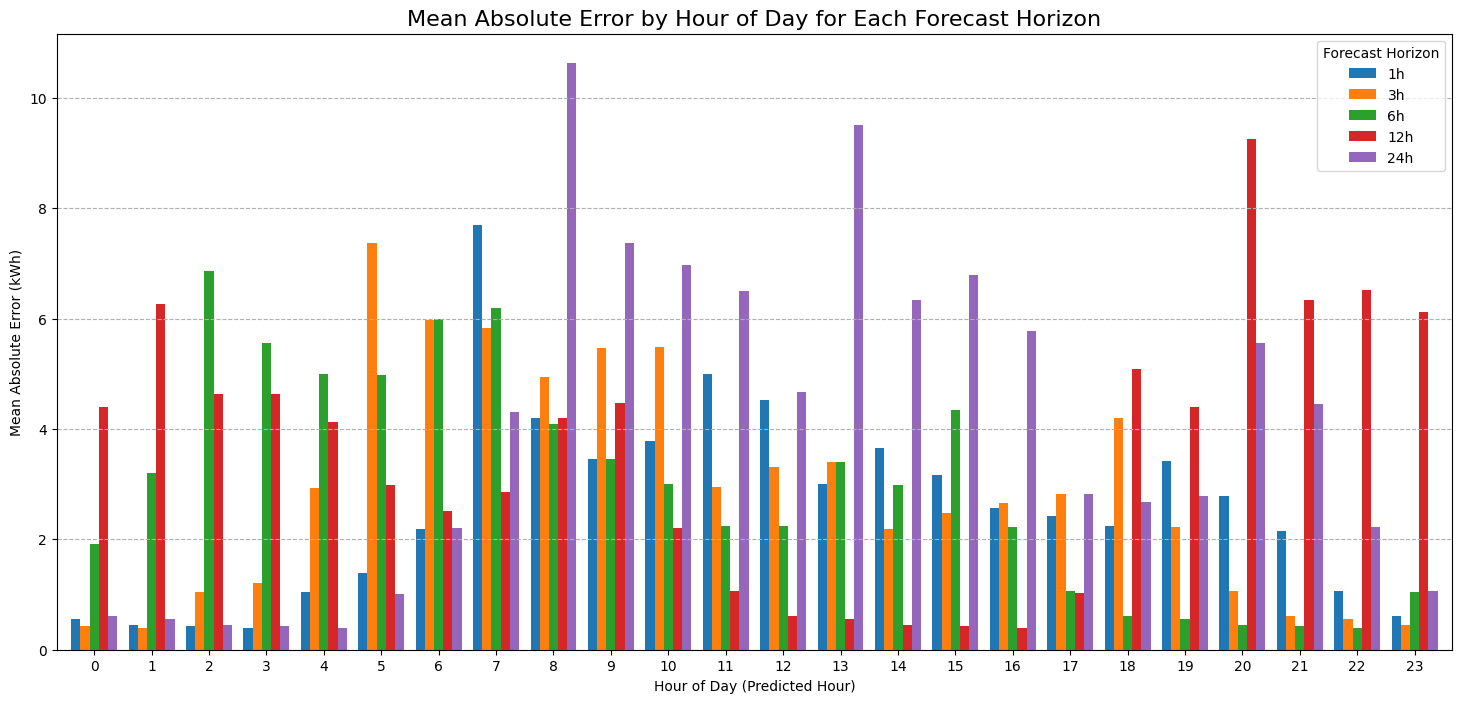

In [11]:
# =============================================================================
# SECTION 8: MULTI-HORIZON FORECASTING WITH THE CHAMPION MODEL (FINAL)
# =============================================================================

# --- 8.1 Define Forecast Horizons and Create Sequences ---
HORIZONS = [1, 3, 6, 12, 24]

def create_multi_step_sequences(features, target, time_steps, horizons):
    X, y = [], []
    max_horizon = max(horizons)
    for i in range(len(features) - time_steps - max_horizon + 1):
        X.append(features[i:(i + time_steps)])
        y.append([target[i + time_steps + h - 1] for h in horizons])
    return np.array(X), np.array(y)

X_train_multi, y_train_multi = create_multi_step_sequences(X_train_scaled, y_train_scaled.ravel(), TIME_STEPS, HORIZONS)
X_test_multi, y_test_multi = create_multi_step_sequences(X_test_scaled, y_test_scaled.ravel(), TIME_STEPS, HORIZONS)
print("Created multi-horizon sequences for the champion model.")

# --- 8.2 Build and Train the Multi-Output Champion Model (Tuned LSTM) ---
# Using the best hyperparameters from Section 5
hp_units_1 = 200
hp_units_2 = 150
hp_dropout = 0.20
hp_learning_rate = 0.001

def build_champion_multi_output_lstm_model(input_shape, num_outputs):
    """Builds the champion multi-output LSTM model with optimal hyperparameters."""
    model = Sequential(name='Multi_Horizon_Tuned_LSTM')
    model.add(LSTM(units=hp_units_1, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(hp_dropout))
    model.add(LSTM(units=hp_units_2, return_sequences=False))
    model.add(Dropout(hp_dropout))
    model.add(Dense(num_outputs, activation='relu'))
    return model

multi_horizon_champion_model = build_champion_multi_output_lstm_model(
    input_shape=(X_train_multi.shape[1], X_train_multi.shape[2]),
    num_outputs=len(HORIZONS)
)
multi_horizon_champion_model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mean_squared_error')
multi_horizon_champion_model.summary()

print("\n--- Training the Champion Multi-Horizon Model ---")
history_multi = multi_horizon_champion_model.fit(
    X_train_multi, y_train_multi,
    epochs=100,
    batch_size=64,
    validation_data=(X_test_multi, y_test_multi),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)],
    verbose=1
)

# --- 8.3 Overall Multi-Horizon Model Evaluation ---
print("\n--- Overall Multi-Horizon Champion Model Evaluation ---")
y_pred_scaled_multi = multi_horizon_champion_model.predict(X_test_multi)
y_pred_multi = scaler_target.inverse_transform(y_pred_scaled_multi)
y_actual_multi = scaler_target.inverse_transform(y_test_multi)

horizon_metrics = []
mean_actual_kwh = y_actual_multi.mean()

for i, h in enumerate(HORIZONS):
    rmse = np.sqrt(mean_squared_error(y_actual_multi[:, i], y_pred_multi[:, i]))
    mae = mean_absolute_error(y_actual_multi[:, i], y_pred_multi[:, i])
    r2 = r2_score(y_actual_multi[:, i], y_pred_multi[:, i])
    nmae = (mae / mean_actual_kwh) * 100
    horizon_metrics.append({'Horizon': f'{h} Hour(s)', 'RMSE (kWh)': rmse, 'MAE (kWh)': mae, 'R-squared': r2, 'NMAE (%)': nmae})

metrics_df = pd.DataFrame(horizon_metrics)
print("\nPerformance Metrics by Forecast Horizon:")
print(metrics_df)

# Plot the overall performance degradation curve
fig, ax1 = plt.subplots(figsize=(12, 7))
ax1.plot(metrics_df['Horizon'], metrics_df['RMSE (kWh)'], marker='o', linestyle='-', color='b', label='RMSE (kWh)')
ax1.plot(metrics_df['Horizon'], metrics_df['MAE (kWh)'], marker='s', linestyle='-', color='c', label='MAE (kWh)')
ax1.set_xlabel('Forecast Horizon')
ax1.set_ylabel('Absolute Error (kWh)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)
ax2 = ax1.twinx()
ax2.plot(metrics_df['Horizon'], metrics_df['R-squared'], marker='d', linestyle='--', color='r', label='R-squared')
ax2.set_ylabel('R-squared', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(0, 1)
fig.suptitle('Champion Model Performance Degradation Over Forecast Horizon', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right')
plt.show()

# --- 8.4 Granular Error Analysis by Hour of Day ---
print("\n--- Granular Error Analysis by Hour of Day ---")
prediction_start_index = TIME_STEPS + max(HORIZONS) - 1
actual_indices = test_df.index[prediction_start_index:]
min_len = min(len(actual_indices), len(y_actual_multi))
actual_indices = actual_indices[:min_len]
y_actual_multi = y_actual_multi[:min_len]
y_pred_multi = y_pred_multi[:min_len]

detailed_results = pd.DataFrame(y_actual_multi, index=actual_indices, columns=[f'Actual_{h}h' for h in HORIZONS])
for i, h in enumerate(HORIZONS):
    detailed_results[f'Predicted_{h}h'] = y_pred_multi[:, i]
    detailed_results[f'Error_{h}h'] = np.abs(detailed_results[f'Actual_{h}h'] - detailed_results[f'Predicted_{h}h'])
detailed_results['Hour'] = detailed_results.index.hour

hourly_error = detailed_results.groupby('Hour')[[f'Error_{h}h' for h in HORIZONS]].mean()
hourly_error.columns = [f'{h}h' for h in HORIZONS]

hourly_error.plot(kind='bar', figsize=(18, 8), width=0.8)
plt.title('Mean Absolute Error by Hour of Day for Each Forecast Horizon', fontsize=16)
plt.xlabel('Hour of Day (Predicted Hour)')
plt.ylabel('Mean Absolute Error (kWh)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.legend(title='Forecast Horizon')
plt.show()

# SECTION 9: ANOMALY DETECTION AND CHARACTERIZATION

--- Anomaly Detection Using the Champion Model (Tuned Baseline LSTM) ---
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Anomaly Threshold (Mean + 3*Std): 10.86 kWh

Found 51 potential anomalies in the test set.

Anomalies found at the following timestamps:
                     Actual_kWh  Predicted_kWh  Error_kWh
Date                                                     
2019-07-19 08:00:00      112.28      93.629997      18.65
2019-07-19 09:00:00      100.75      89.320000      11.42
2019-07-22 09:00:00      112.28      97.269997      15.01
2019-07-22 11:00:00       83.83      72.440002      11.38
2019-07-29 07:00:00        0.92      11.820000      10.90
2019-07-29 08:00:00        1.12      36.910000      35.78
2019-07-29 14:00:00        6.69      18.430000      11.74
2019-07-30 09:00:00      112.28      97.930000      14.36
2019-07-30 10:00:00      112.28      96.690002      15.59
2019-07-31 08:00:00      112.28      98.279999      14.00
2019-08-01 13:00:00       79.92      90.900002      10

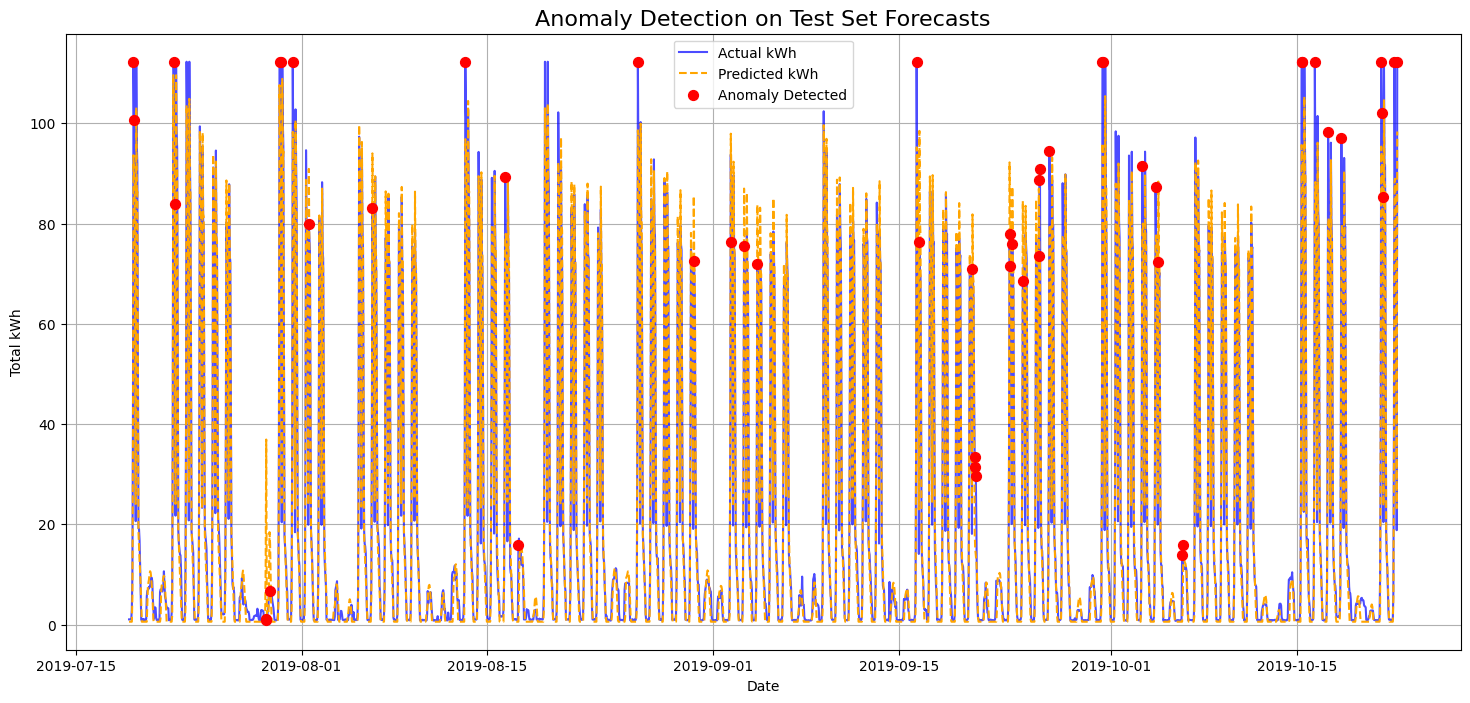


--- Characterizing the Detected Anomalies ---


/var/folders/7j/czphbg2d2_v9hhk42wc_q6dh0000gn/T/ipykernel_18700/1928862126.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Hour', data=anomalies, palette='viridis', order=range(24))


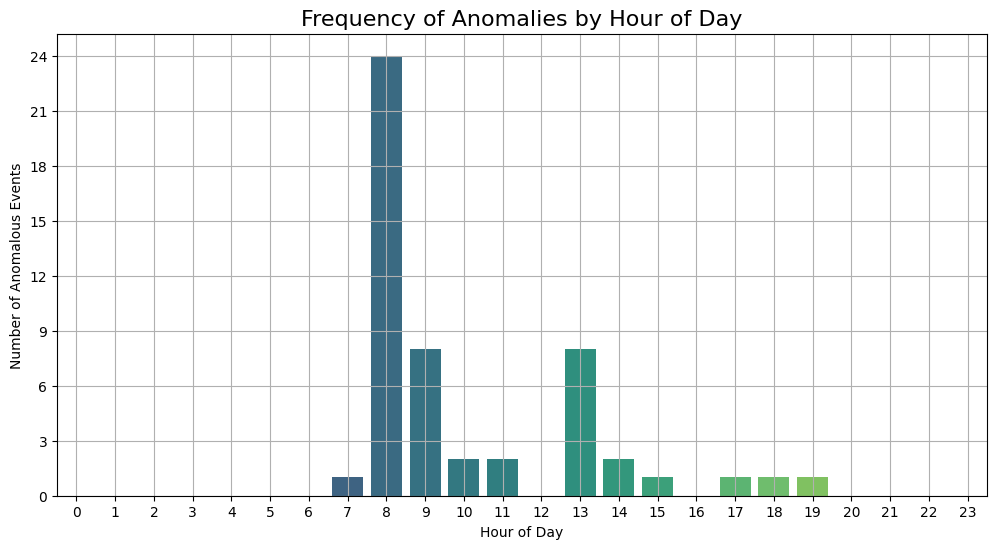

/var/folders/7j/czphbg2d2_v9hhk42wc_q6dh0000gn/T/ipykernel_18700/1928862126.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='DayOfWeek', data=anomalies, palette='plasma', order=range(7))


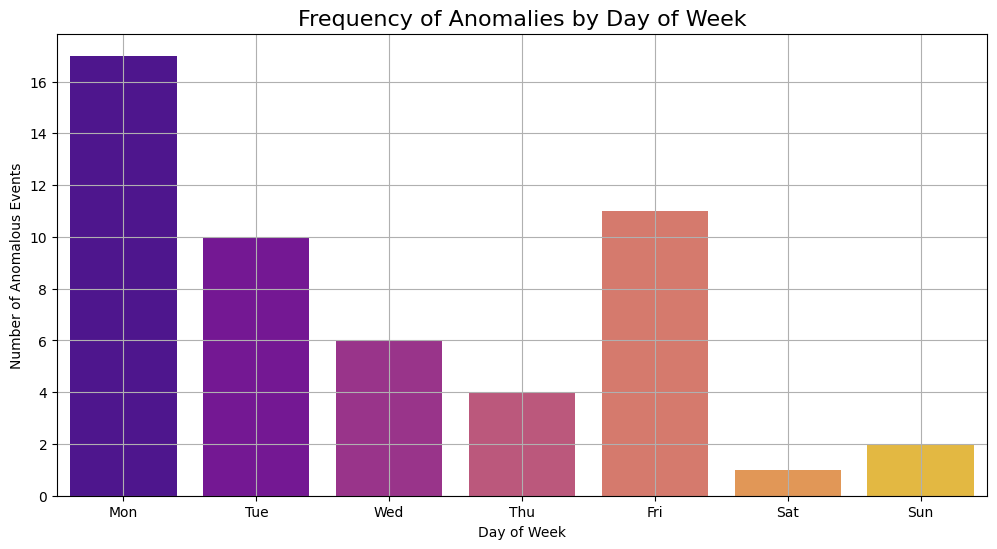

In [12]:
# =============================================================================
# SECTION 9: ANOMALY DETECTION AND CHARACTERIZATION
# =============================================================================

# --- 9.1 Import Additional Libraries ---
from matplotlib.ticker import MaxNLocator

# --- 9.2 Load and Use the Champion One-Step Model ---
# We use our champion model, the 'Tuned Baseline LSTM', from Section 5.
print("--- Anomaly Detection Using the Champion Model (Tuned Baseline LSTM) ---")

# --- 9.3 Generate Predictions on the Test Set ---
y_pred_scaled = best_lstm_model.predict(X_test_1step)
y_pred = scaler_target.inverse_transform(y_pred_scaled)
y_actual = scaler_target.inverse_transform(y_test_1step.reshape(-1, 1))

# --- 9.4 Calculate Prediction Errors (Residuals) ---
errors = np.abs(y_actual - y_pred)
results_df = test_df.iloc[TIME_STEPS:].copy()
results_df['Actual_kWh'] = y_actual
results_df['Predicted_kWh'] = y_pred
results_df['Error_kWh'] = errors

# --- 9.5 Define the Anomaly Threshold ---
error_mean = results_df['Error_kWh'].mean()
error_std = results_df['Error_kWh'].std()
anomaly_threshold = error_mean + (3 * error_std)
print(f"Anomaly Threshold (Mean + 3*Std): {anomaly_threshold:.2f} kWh")

# --- 9.6 Identify and Visualize Anomalies ---
results_df['Is_Anomaly'] = results_df['Error_kWh'] > anomaly_threshold
anomalies = results_df[results_df['Is_Anomaly']]
print(f"\nFound {len(anomalies)} potential anomalies in the test set.")
print("\nAnomalies found at the following timestamps:")
print(anomalies[['Actual_kWh', 'Predicted_kWh', 'Error_kWh']].round(2))

# Plot the anomalies on the main time-series graph
plt.figure(figsize=(18, 8))
plt.plot(results_df.index, results_df['Actual_kWh'], label='Actual kWh', color='blue', alpha=0.7)
plt.plot(results_df.index, results_df['Predicted_kWh'], label='Predicted kWh', color='orange', linestyle='--')
plt.scatter(anomalies.index, anomalies['Actual_kWh'], color='red', s=50, label='Anomaly Detected', zorder=5)
plt.title('Anomaly Detection on Test Set Forecasts', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Total kWh')
plt.legend()
plt.grid(True)
plt.show()

# --- 9.7 Anomaly Characterization ---
print("\n--- Characterizing the Detected Anomalies ---")

# Plot 1: Distribution of Anomalies by Hour of Day
ax = plt.figure(figsize=(12, 6)).gca()
sns.countplot(x='Hour', data=anomalies, palette='viridis', order=range(24))
plt.title('Frequency of Anomalies by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Anomalous Events')
# **REVISION**: Force the y-axis to use integer ticks.
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)
plt.show()

# Plot 2: Distribution of Anomalies by Day of Week
ax = plt.figure(figsize=(12, 6)).gca()
sns.countplot(x='DayOfWeek', data=anomalies, palette='plasma', order=range(7))
plt.title('Frequency of Anomalies by Day of Week', fontsize=16)
plt.xlabel('Day of Week')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.ylabel('Number of Anomalous Events')
# **REVISION**: Force the y-axis to use integer ticks.
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)
plt.show()

# SECTION 10: CROSS-FLOOR TRANSFER LEARNING


--- Preparing Data for Target Floor (Floor 4) ---

--- Scenario 1: Training a new model from scratch on limited Floor 4 data ---


/Users/soheil/anaconda3/envs/tf_m1/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Result: Test RMSE for model trained from scratch = 20.78 kWh

--- Scenario 2: Applying Transfer Learning ---
Frozen the feature extraction layers of the champion model.


Model: "Baseline_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 200)        │       169,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 290,101 (1.11 MB)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 290,000 (1.11 MB)


Fine-tuning the final layer on limited Floor 4 data...
388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Result: Test RMSE for transfer learning model = 5.76 kWh

--- Transfer Learning Conclusion ---
Transfer learning resulted in a 72.28% improvement in RMSE over training from scratch.


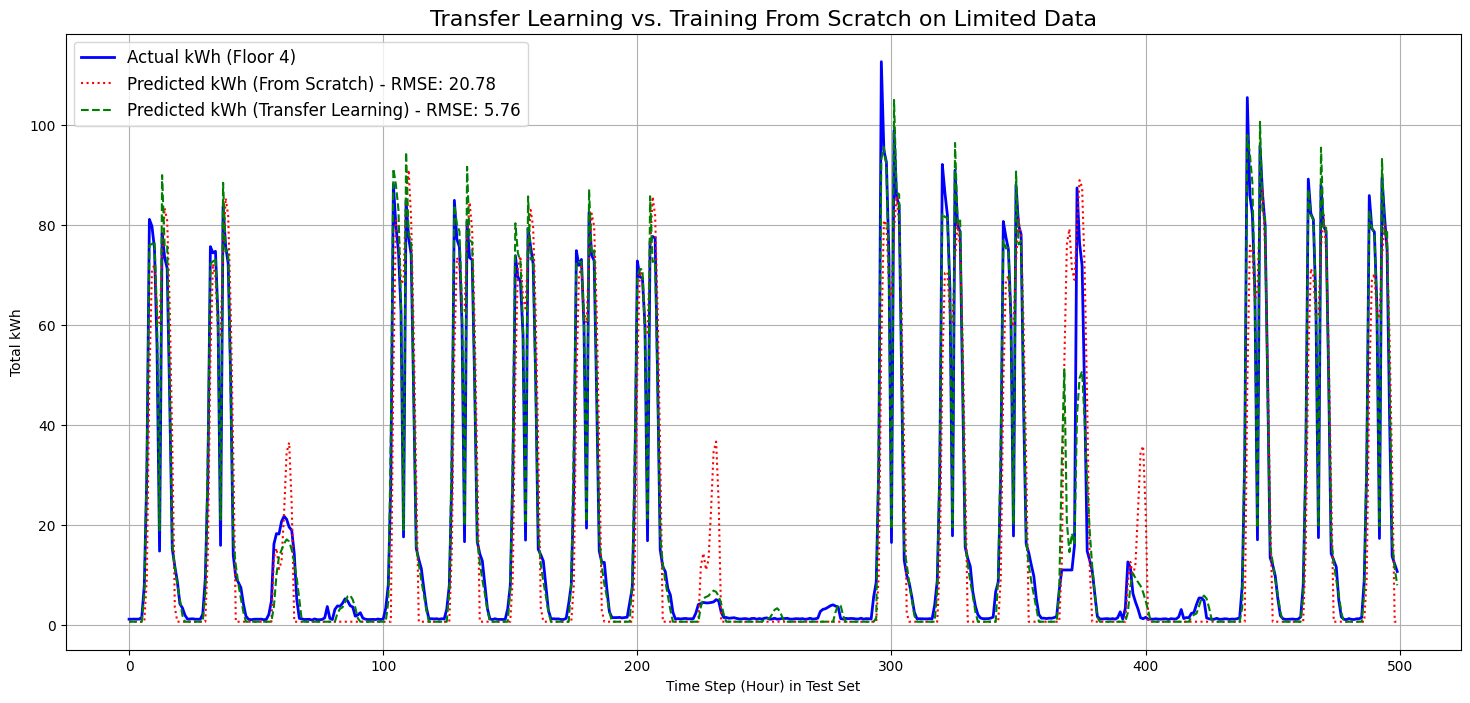

In [13]:
# =============================================================================
# SECTION 10: CROSS-FLOOR TRANSFER LEARNING
# =============================================================================

# --- 10.1 Prepare the Target Floor Data (Floor 4) ---

print("\n--- Preparing Data for Target Floor (Floor 4) ---")
df_floor4 = all_floors['Floor4'].copy()

# Perform the same preprocessing steps as for Floor 6
df_floor4['Date'] = pd.to_datetime(df_floor4['Date'])
df_floor4.set_index('Date', inplace=True)
energy_columns_f4 = [col for col in df_floor4.columns if col.endswith('(kW)')]
df_energy_f4 = df_floor4[energy_columns_f4].copy()
df_energy_f4.ffill(inplace=True)
df_energy_f4.bfill(inplace=True)
df_energy_f4['Total_kW'] = df_energy_f4.sum(axis=1)

# **CORRECTION**: Use .mean() for correct power-to-energy conversion, consistent with Section 2.
df_hourly_f4 = df_energy_f4[['Total_kW']].resample('h').mean()
df_hourly_f4.rename(columns={'Total_kW': 'Total_kWh'}, inplace=True)


# Create features for Floor 4
df_hourly_f4 = create_features(df_hourly_f4) 
df_hourly_f4['IsHoliday'] = df_hourly_f4.index.normalize().isin(holidays).astype(int)
df_hourly_f4 = encode_cyclical(df_hourly_f4, 'Hour', 24)
df_hourly_f4 = encode_cyclical(df_hourly_f4, 'DayOfWeek', 7)
df_hourly_f4 = encode_cyclical(df_hourly_f4, 'Month', 12)
df_hourly_f4 = encode_cyclical(df_hourly_f4, 'WeekOfYear', 52)

# --- 10.2 Create a "Low-Data" Scenario for Floor 4 ---
f4_train_df = df_hourly_f4.loc['2018-07-01':'2018-07-31'].copy()
f4_test_df = df_hourly_f4.loc['2018-08-01':].copy()

# --- 10.3 Scale Floor 4 Data ---
X_f4_train_df = f4_train_df[feature_columns]
y_f4_train_df = f4_train_df[[target_column]]
X_f4_test_df = f4_test_df[feature_columns]
y_f4_test_df = f4_test_df[[target_column]]

X_f4_train_scaled = scaler_features.transform(X_f4_train_df)
y_f4_train_scaled = scaler_target.transform(y_f4_train_df)
X_f4_test_scaled = scaler_features.transform(X_f4_test_df)
y_f4_test_scaled = scaler_target.transform(y_f4_test_df)

# --- 10.4 Create Sequences for Floor 4 ---
# Using the robust, locally-defined function from our Utilities section
X_train_f4, y_train_f4 = create_sequences(X_f4_train_scaled, y_f4_train_scaled.ravel(), TIME_STEPS)
X_test_f4, y_test_f4 = create_sequences(X_f4_test_scaled, y_f4_test_scaled.ravel(), TIME_STEPS)


# --- 10.5 Scenario 1: Train a Model from Scratch on Low Data ---
print("\n--- Scenario 1: Training a new model from scratch on limited Floor 4 data ---")
# Re-set seeds immediately before model creation and training for robustness.
tf.random.set_seed(42)
np.random.seed(42)

scratch_model = tuner_lstm.hypermodel.build(best_hps_lstm) # Use the best LSTM hyperparams from Section 5
scratch_model.fit(X_train_f4, y_train_f4, epochs=50, batch_size=32, verbose=0, callbacks=[EarlyStopping(monitor='loss', patience=5)])
y_pred_scratch_scaled = scratch_model.predict(X_test_f4)
y_pred_scratch = scaler_target.inverse_transform(y_pred_scratch_scaled)
y_actual_f4 = scaler_target.inverse_transform(y_test_f4.reshape(-1, 1))
rmse_scratch = np.sqrt(mean_squared_error(y_actual_f4, y_pred_scratch))
print(f"Result: Test RMSE for model trained from scratch = {rmse_scratch:.2f} kWh")

# --- 10.6 Scenario 2: Transfer Learning ---
print("\n--- Scenario 2: Applying Transfer Learning ---")
# Re-set seeds immediately before fine-tuning for robustness.
tf.random.set_seed(42)
np.random.seed(42)

transfer_model = tf.keras.models.clone_model(best_lstm_model)
transfer_model.set_weights(best_lstm_model.get_weights())
for layer in transfer_model.layers[:-1]:
    layer.trainable = False
transfer_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
print("Frozen the feature extraction layers of the champion model.")
transfer_model.summary()

print("\nFine-tuning the final layer on limited Floor 4 data...")
transfer_model.fit(X_train_f4, y_train_f4, epochs=50, batch_size=32, verbose=0, callbacks=[EarlyStopping(monitor='loss', patience=5)])
y_pred_transfer_scaled = transfer_model.predict(X_test_f4)
y_pred_transfer = scaler_target.inverse_transform(y_pred_transfer_scaled)
rmse_transfer = np.sqrt(mean_squared_error(y_actual_f4, y_pred_transfer))
print(f"Result: Test RMSE for transfer learning model = {rmse_transfer:.2f} kWh")

# --- 10.7 Conclusion & Visualization ---
print("\n--- Transfer Learning Conclusion ---")
improvement = ((rmse_scratch - rmse_transfer) / rmse_scratch) * 100
print(f"Transfer learning resulted in a {improvement:.2f}% improvement in RMSE over training from scratch.")

plot_range = 500
plt.figure(figsize=(18, 8))
plt.plot(y_actual_f4[:plot_range], label='Actual kWh (Floor 4)', color='blue', linewidth=2)
plt.plot(y_pred_scratch[:plot_range], label=f'Predicted kWh (From Scratch) - RMSE: {rmse_scratch:.2f}', color='red', linestyle=':')
plt.plot(y_pred_transfer[:plot_range], label=f'Predicted kWh (Transfer Learning) - RMSE: {rmse_transfer:.2f}', color='green', linestyle='--')
plt.title('Transfer Learning vs. Training From Scratch on Limited Data', fontsize=16)
plt.xlabel('Time Step (Hour) in Test Set')
plt.ylabel('Total kWh')
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# SECTION 11: BUILDING-WIDE ENERGY PROFILING AND BENCHMARKING METRICS

--- Processing Data for All Floors to Create Building-Wide Profile ---
Successfully created a building-wide hourly energy consumption profile.

--- Key Building Energy Benchmarking Metrics (July 2018 - June 2019) ---
                                     Metric       Value
0       Total Annual Consumption (kWh/year)  2403504.78
1  Energy Use Intensity (EUI) (kWh/m²/year)      205.43
2                     Peak Hourly Load (kW)      879.51
3                  Average Hourly Load (kW)      274.37
4                    Base Load (Approx. kW)      112.66
5                               Load Factor        0.31


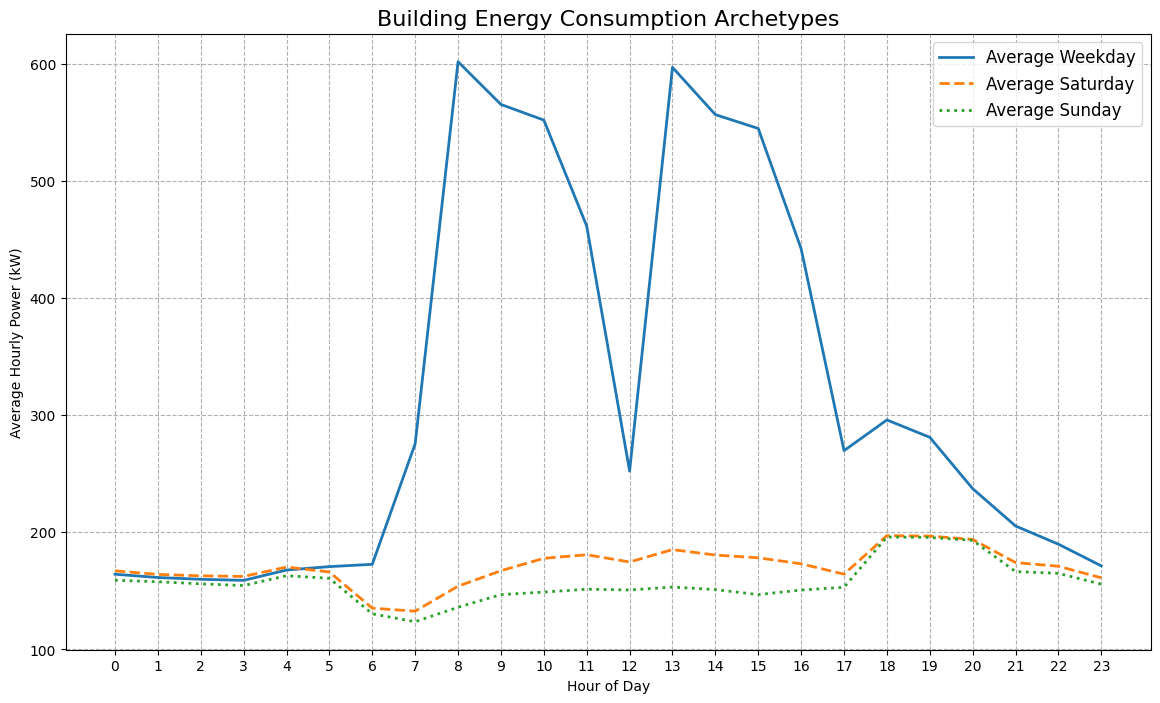

In [14]:
# =============================================================================
# SECTION 11: BUILDING-WIDE ENERGY PROFILING AND BENCHMARKING METRICS
# =============================================================================

# --- 11.1 Consolidate and Process Data for All Floors ---

print("--- Processing Data for All Floors to Create Building-Wide Profile ---")

# Building floor area in square meters (confirmed from the source paper)
BUILDING_AREA_M2 = 11700

all_floors_kwh = []

# Loop through all loaded floor dataframes
for floor_name, df_raw in all_floors.items():
    # Perform the same initial preprocessing on each floor
    df_proc = df_raw.copy()
    df_proc['Date'] = pd.to_datetime(df_proc['Date'])
    df_proc.set_index('Date', inplace=True)
    
    energy_cols = [col for col in df_proc.columns if col.endswith('(kW)')]
    df_energy = df_proc[energy_cols].copy()
    
    # Handle missing values robustly
    df_energy.ffill(inplace=True)
    df_energy.bfill(inplace=True)
    
    # Calculate total kW for the floor
    df_energy['Total_kW'] = df_energy.sum(axis=1)
    
    # **CORRECTION**: To convert minute-level power (kW) to hourly energy (kWh),
    # we must take the MEAN of the power readings over the hour.
    df_hourly = df_energy[['Total_kW']].resample('h').mean()
    df_hourly.rename(columns={'Total_kW': f'{floor_name}_kWh'}, inplace=True)
    all_floors_kwh.append(df_hourly)

# Combine all floor data into a single dataframe
df_building = pd.concat(all_floors_kwh, axis=1)

# Calculate the total building consumption
df_building['Building_Total_kWh'] = df_building.sum(axis=1)

print("Successfully created a building-wide hourly energy consumption profile.")

# --- 11.2 Calculate Key Benchmarking Metrics ---

# We will analyze a full year of data for annual metrics.
# The period from July 1, 2018, to June 30, 2019, is a complete 12-month cycle.
df_year = df_building.loc['2018-07-01':'2019-06-30'].copy()

# Total Annual Consumption
total_annual_kwh = df_year['Building_Total_kWh'].sum()

# Energy Use Intensity (EUI)
eui = total_annual_kwh / BUILDING_AREA_M2

# Peak Load (this is now the maximum average hourly power in kW)
peak_load_kw = df_year['Building_Total_kWh'].max()

# Average Load
average_load_kw = df_year['Building_Total_kWh'].mean()

# Load Factor
load_factor = average_load_kw / peak_load_kw

# Base Load (approximated by the 10th percentile of consumption)
base_load_kw = df_year['Building_Total_kWh'].quantile(0.10)

# Create a DataFrame to display the results clearly
benchmarking_metrics = {
    'Metric': [
        'Total Annual Consumption (kWh/year)',
        'Energy Use Intensity (EUI) (kWh/m²/year)',
        'Peak Hourly Load (kW)',
        'Average Hourly Load (kW)',
        'Base Load (Approx. kW)',
        'Load Factor'
    ],
    'Value': [
        total_annual_kwh,
        eui,
        peak_load_kw,
        average_load_kw,
        base_load_kw,
        load_factor
    ]
}
metrics_df = pd.DataFrame(benchmarking_metrics)

print("\n--- Key Building Energy Benchmarking Metrics (July 2018 - June 2019) ---")
print(metrics_df.round(2))

# --- 11.3 Generate Daily Energy Profile Archetypes ---

df_year['Hour'] = df_year.index.hour
df_year['DayType'] = df_year.index.dayofweek.map({
    0: 'Weekday', 1: 'Weekday', 2: 'Weekday', 3: 'Weekday', 4: 'Weekday',
    5: 'Saturday', 6: 'Sunday'
})

# Group by day type and hour to get the average power profiles
profile_df = df_year.groupby(['DayType', 'Hour'])['Building_Total_kWh'].mean().unstack(level=0)

# Plot the archetypes
plt.figure(figsize=(14, 8))
plt.plot(profile_df.index, profile_df['Weekday'], label='Average Weekday', linewidth=2)
plt.plot(profile_df.index, profile_df['Saturday'], label='Average Saturday', linestyle='--', linewidth=2)
plt.plot(profile_df.index, profile_df['Sunday'], label='Average Sunday', linestyle=':', linewidth=2)

plt.title('Building Energy Consumption Archetypes', fontsize=16)
plt.xlabel('Hour of Day')
# **REVISION**: Corrected the y-axis label to be more precise.
plt.ylabel('Average Hourly Power (kW)')
plt.xticks(np.arange(0, 24, 1))
plt.grid(True, which='both', linestyle='--')
plt.legend(fontsize=12)
plt.show()